In [1]:
import os
import yaml
import pickle
import matplotlib
import gc

import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.ticker as ticker
import torchvision
from scipy import stats
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer
import scipy

import bilby
import pandas as pd
from pprint import pprint

matplotlib.use('pdf')

os.environ['MPLCONFIGDIR'] = '/home/local/nihargupte'
import dingo.gw.dataset.generate_dataset 
from dingo.gw.dataset import WaveformDataset
import dingo.gw.training.train_builders
from dingo.gw.ASD_dataset.noise_dataset import ASDDataset
import dingo.gw.waveform_generator
from dingo.gw.domains import build_domain, build_domain_from_model_metadata
import dingo.gw.inference
from dingo.gw.gwutils import get_window_factor
from dingo.gw.transforms import *
from dingo.core.models import PosteriorModel
from dingo.gw.inference import injection
from dingo.gw.inference.gw_samplers import GWSamplerGNPE, GWSampler

from utils import get_snr

%matplotlib inline
%load_ext autoreload
%autoreload 2

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-9n7xkx2f because the default path (/home/nihargupte/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


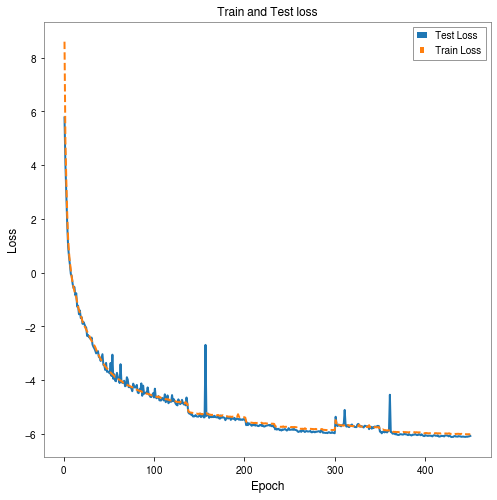

In [3]:
df = pd.read_csv("/home/local/nihargupte/dingo-devel/tutorials/03_aligned_spin/train_dir_SEOBNRv4HM_ROM_O1_2048_lr_time/history.txt", delimiter='\t', header=None)
df.columns = ['epoch', 'train_loss', 'test_loss', '*learning_rates']
plt.figure(figsize=(8, 8))
plt.title('Train and Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(df['epoch'], df['test_loss'], label='Test Loss', linewidth=2)
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', linestyle='--', linewidth=2)
plt.grid()
plt.legend()


In [4]:
approximant = "SEOBNRv4HM_ROM"
special = "_O1_2048_lr"
models_dir = "/home/local/nihargupte/dingo-devel/tutorials/03_aligned_spin"
waveform_generation_dir = '/home/local/nihargupte/dingo-devel/tutorials/03_aligned_spin/datasets/waveforms'
os.environ["LAL_DATA_PATH"] = "/home/local/nihargupte/dingo-devel/venv/lib/python3.9/site-packages/lalsimulation/"


In [6]:
folder = 1
bilby_result = bilby.result.read_in_result(filename=f'/home/local/nihargupte/dingo-devel/tutorials/05_data_vis/{approximant}{special}_comparison/{folder}/outdir/label_result.json')
with open(f'/home/local/nihargupte/dingo-devel/tutorials/05_data_vis/{approximant}{special}_comparison/{folder}/strain_data.pkl', 'rb') as f:
    strain_data = pickle.load(f)

In [8]:
torch.cuda.set_device(4)

# build posterior model
main_pm = PosteriorModel(
    device="cuda",
    **{"model_filename": f"{models_dir}/train_dir_{approximant}{special}/model_latest.pt"},
    load_training_info=False
)

time_pm = PosteriorModel(
    device='cuda',
    **{"model_filename": f"{models_dir}/train_dir_{approximant}_O1_2048_time/model_latest.pt"},
    load_training_info=False
)

Putting posterior model to device cuda.
Putting posterior model to device cuda.


In [9]:
theta = strain_data["parameters"].copy()
init_sampler = GWSampler(model=time_pm)
sampler = GWSamplerGNPE(model=main_pm, init_sampler=init_sampler, num_iterations=60)
sampler.context = strain_data
sampler.run_sampler(
    num_samples=50_000,
    batch_size=10_000,
)
total_mass = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_total_mass(sampler.samples["chirp_mass"], sampler.samples["mass_ratio"])
mass_1, mass_2 = bilby.gw.conversion.total_mass_and_mass_ratio_to_component_masses(sampler.samples["mass_ratio"], total_mass)
sampler.samples["mass_1"] = mass_1
sampler.samples["mass_2"] = mass_2

bilby_result.samples_to_posterior()
total_mass = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_total_mass(bilby_result.posterior["chirp_mass"], bilby_result.posterior["mass_ratio"])
mass_1, mass_2 = bilby.gw.conversion.total_mass_and_mass_ratio_to_component_masses(bilby_result.posterior["mass_ratio"], total_mass)
bilby_result.posterior["mass_1"] = mass_1
bilby_result.posterior["mass_2"] = mass_2


GNPE parameters:  ['H1_time', 'L1_time']


/home/local/nihargupte/dingo-devel/venv/lib/python3.9/site-packages/bilby/gw/utils.py:81: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  omega = np.array([np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)])
/home/local/nihargupte/dingo-devel/venv/lib/python3.9/site-packages/bilby/gw/utils.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  omeg

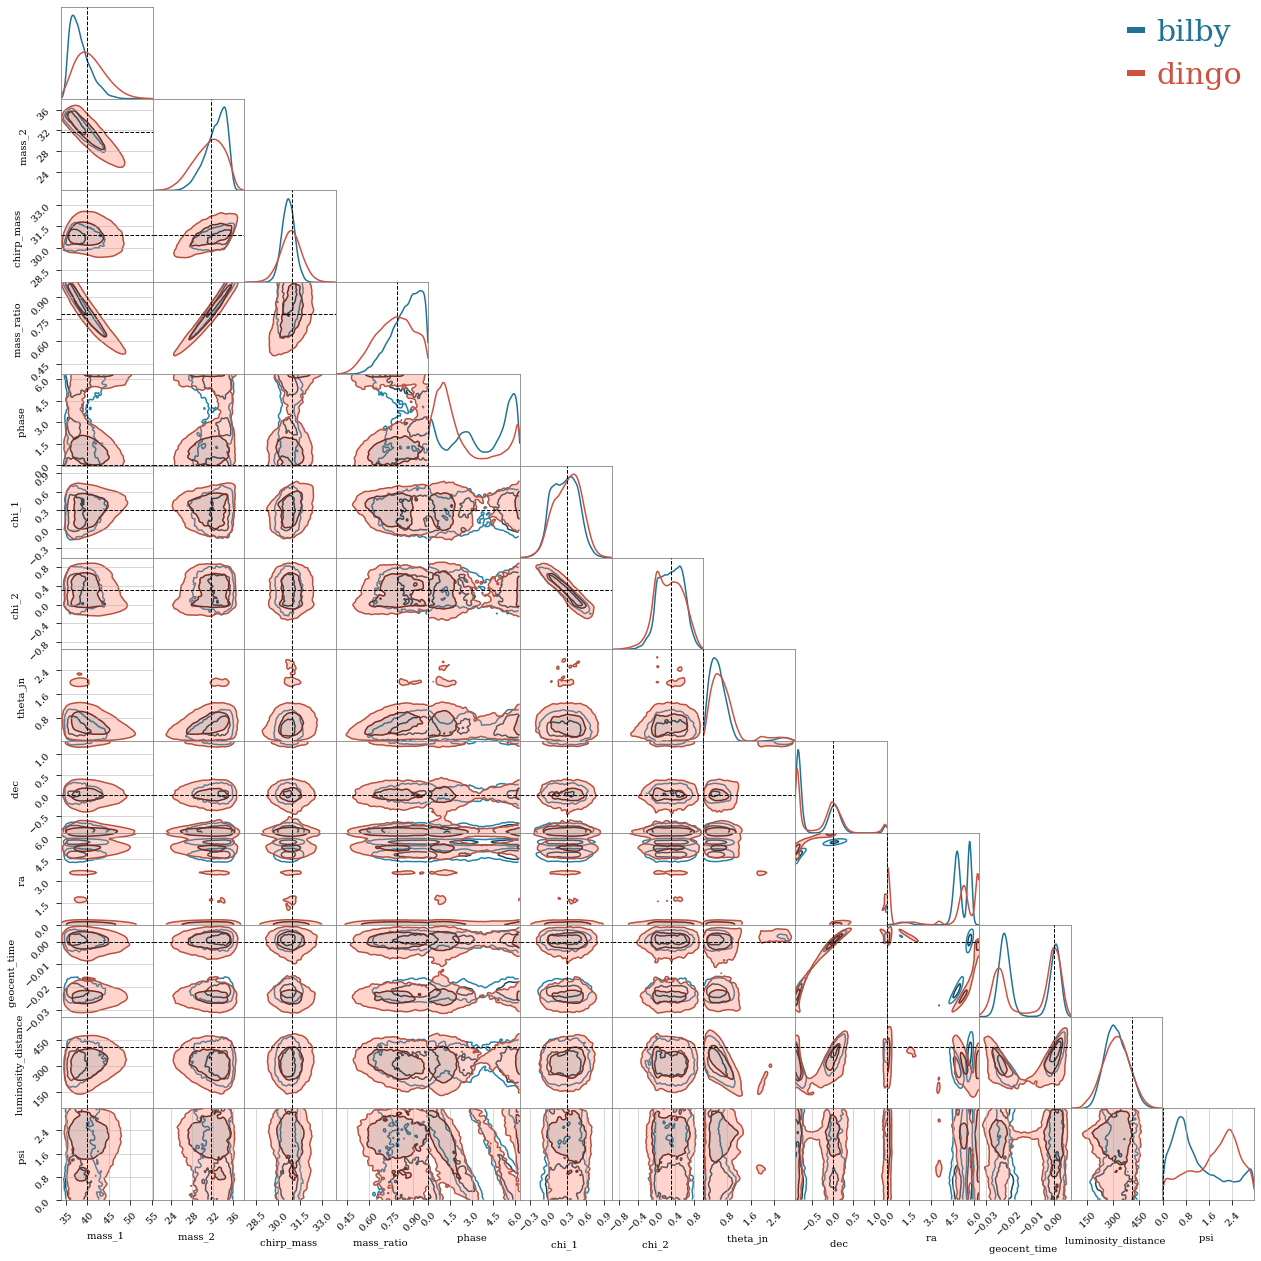

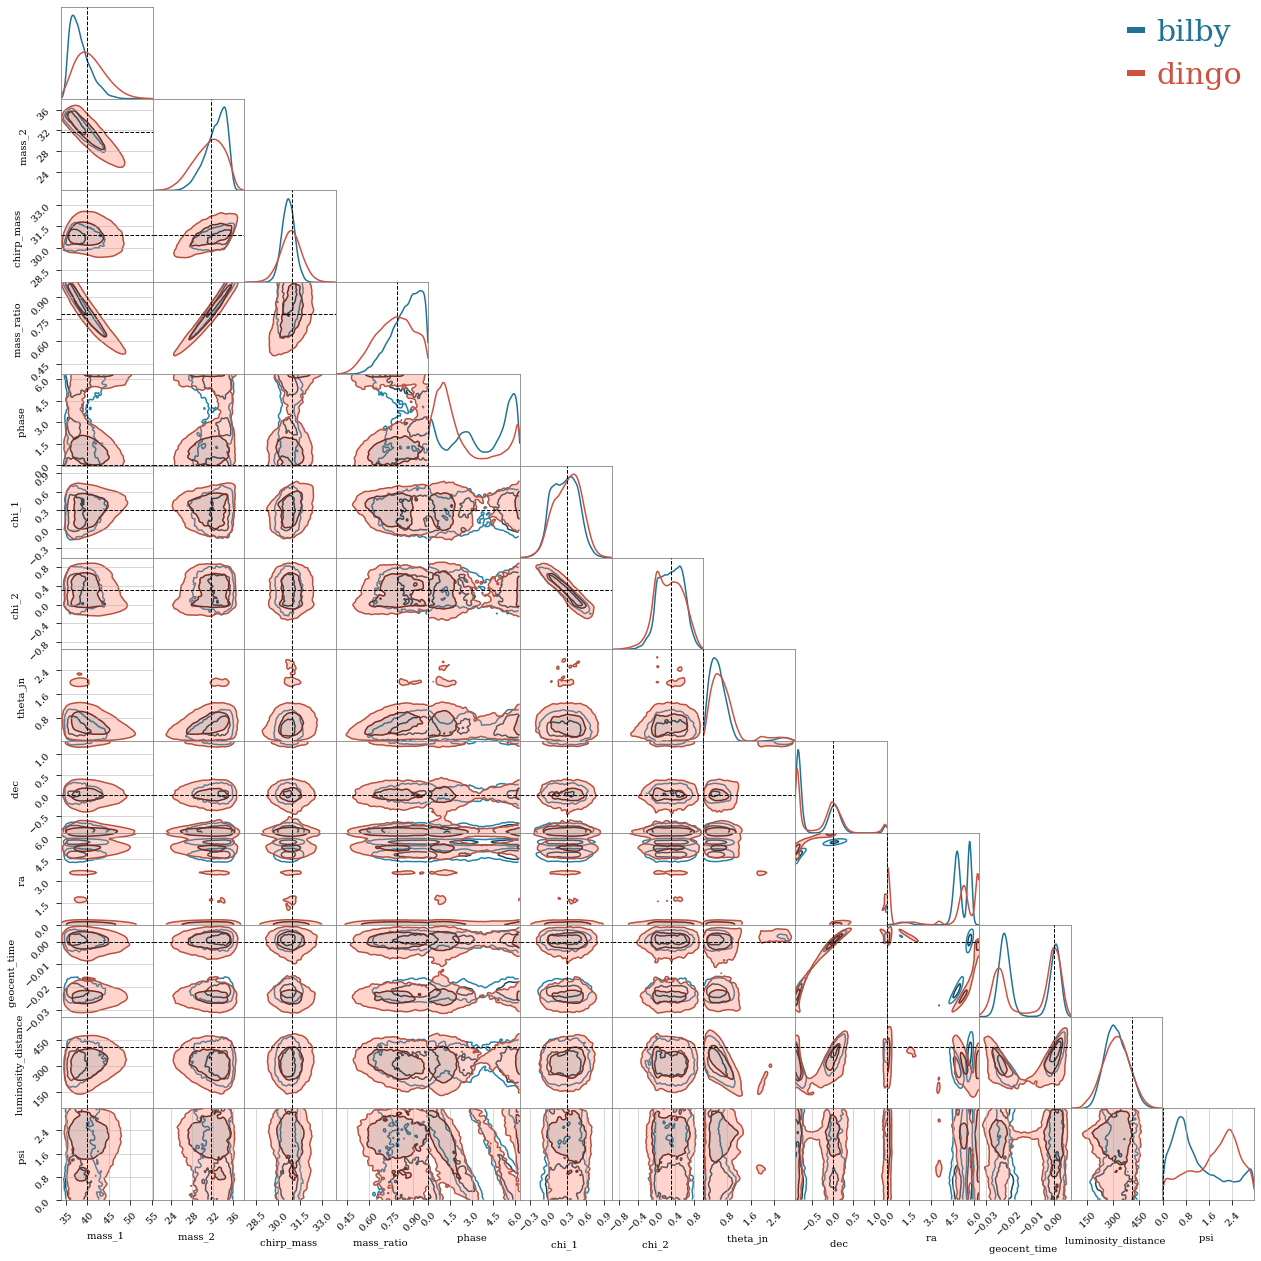

In [11]:
charizard_hex = ('#cd5241', '#084152', '#eede7b', '#207394', '#eeb45a', '#e64110', '#ff524a', '#f6a410', '#08398b', '#626262', '#833118')
plt.rcParams['text.usetex'] = False
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['font.size'] = 15
plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=charizard_hex)

labels = [
    "mass_1",
    "mass_2",
    "chirp_mass",
    "mass_ratio",
    "phase",
    "chi_1",
    "chi_2",
    "theta_jn",
    "dec",
    "ra",
    "geocent_time",
    "luminosity_distance",
    "psi",
]
N = 2
c = ChainConsumer()
bilby_posterier = bilby_result.posterior[labels].to_dict('list')
c.add_chain(bilby_posterier, color=charizard_hex[3], name='bilby')
c.add_chain(sampler.samples, color=charizard_hex[0], name='dingo')
c.configure(
    linestyles=["-"] * N,
    linewidths=[1.5] * N,
    sigmas=[np.sqrt(2) * scipy.special.erfinv(x) for x in [0.5, 0.9]],
    shade=[False] + [True] * (N - 1),
    shade_alpha=0.3,
    bar_shade=False,
    label_font_size=10,
    tick_font_size=10,
    usetex=False,
    legend_kwargs={"fontsize": 30},
    # kde=0.7
)

c.plotter.plot(truth=theta)# , filename=f'/home/local/nihargupte/dingo-devel/tutorials/05_data_vis/{approximant}{special}_comparison/{folder}/corner.pdf')

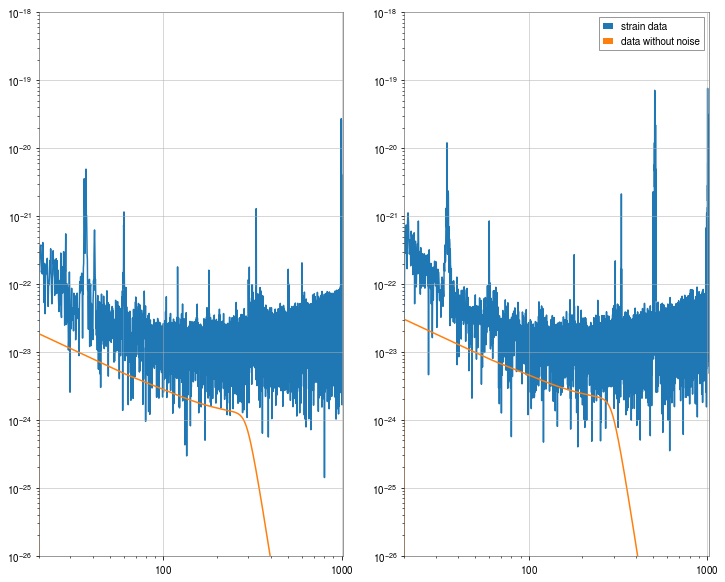

In [15]:
# Plotting signal and noise
fig, axes = plt.subplots(1, 2, figsize=(12, 10))

# Generate
injection_generator.whiten = False
strain_data_no_noise = injection_generator.signal(theta)
axes[0].set_xlim([20, 1024])
axes[0].set_ylim([1e-26, 1e-18])
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].plot(sampler.domain.sample_frequencies, np.abs(strain_data["waveform"]["H1"]), label="strain data")
axes[0].plot(sampler.domain.sample_frequencies, np.abs(strain_data_no_noise["waveform"]["H1"]), label="data without noise")
axes[1].set_xlim([20, 1024])
axes[1].set_ylim([1e-26, 1e-18])
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].plot(sampler.domain.sample_frequencies, np.abs(strain_data["waveform"]["L1"]), label="strain data")
axes[1].plot(sampler.domain.sample_frequencies, np.abs(strain_data_no_noise["waveform"]["L1"]), label="data without noise")
plt.legend()